In [1]:
import os
import torch
import cheetah 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import torch.nn as nn

## Get lattice from Bmad into Cheetah

#### Load lattice from bmad

In [2]:
# cu_hxr_file_path = (
#     Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
# )
BEAMPATH = "cu_hxr/cu_hxr.lat.bmad"
cu_hxr_file_path = f'/sdf/home/j/jmorgan/beamphysics/lcls-lattice/bmad/models/{BEAMPATH}'

cu_hxr_file_path = f'/sdf/home/j/jmorgan/beamphysics/lcls-lattice/bmad/models/{BEAMPATH}'
lcls_lattice_dir = '/sdf/home/j/jmorgan/beamphysics/lcls-lattice' #os.environ["LCLS_LATTICE"]
lcls_cu_segment = (
    cheetah.Segment.from_bmad(
    str(cu_hxr_file_path),
    environment_variables={"LCLS_LATTICE": lcls_lattice_dir},
    
))

#lcls_lattice_dir

In [3]:
lcls_cu_segment = lcls_cu_segment.flattened()
len(lcls_cu_segment.elements)


2267

## Bmad

In [4]:
from pytao import Tao
import pandas as pd
from util_bmad import tc, get_output, print_twiss

In [5]:
def tc(cmd, verbose: bool = False):
    result = tao.cmd(cmd)
    if verbose:
        for l in result:
            print(l)

In [6]:
#track_start_element_name = 'begl3'#'endl1'#'beginning'#'begltuh' #'begbsyh_1' #'begl3'

track_start_element_name = 'begltuh'

track_end_element_name = 'endltuh' #'endltuh'#'end' #'endclth_0'

In [7]:
#CU_HXR model
BEAMPATH = 'cu_hxr'
OPTIONS = f'-slice {track_start_element_name}:{track_end_element_name} -noplot '
# OPTIONS = f'-slice {track_start_element_name}: -noplot '
INIT = f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init {OPTIONS}'
tao = Tao(INIT)
#tc('set ele  *::BEGUNDH:ENDUNDH  field_master=True') #QHXHs
# tc('set ele BEGINNING:END field_master=True')

bmad_output = get_output(tao)

In [8]:
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)

In [9]:
e_collimators_eles = floorplan[floorplan['ElementType']=='ECollimator']['ElementName'].tolist()
print(e_collimators_eles)
r_collimators_eles = floorplan[floorplan['ElementType']=='RCollimator']['ElementName'].tolist()
print(r_collimators_eles)
sbend_collimators_eles = floorplan[floorplan['ElementType']=='SBend']['ElementName'].tolist()
print(sbend_collimators_eles)

['PCTDKIK1', 'PCTDKIK2', 'PCTDKIK3', 'PCTDKIK4', 'PCMUON']
['CEDL1', 'CYBX32', 'CXQT22', 'CEDL3', 'CYBX36']
['BY1', 'BY2', 'BX31', 'BX32', 'BCX321', 'BCX322', 'BCX323', 'BCX324', 'BYKIK1', 'BYKIK2', 'BCX351', 'BCX352', 'BCX353', 'BCX354', 'BX35', 'BX36', 'BCX361', 'BCX362', 'BCX363', 'BCX364']


In [10]:
# Convert 'ElementName' column to a set for faster lookup
floorplan_elements = set(floorplan['ElementName'])

# Check if each element in bmad_output['ele.name'] exists in floorplan['ElementName']
for ele in bmad_output['ele.name']:
    if ele in floorplan_elements:
        pass
        # print(f"{ele} exists in floorplan.")
    else:
        print(f"{ele} does not exist in floorplan.")

BEGINNING does not exist in floorplan.
RWWAKE4H does not exist in floorplan.
ENDLTUH does not exist in floorplan.


## Cheetah 

In [11]:
def find_element_index_by_name(module_list, name):
    name_lower = name.lower()
    for idx, element in enumerate(module_list):
        if hasattr(element, 'name') and element.name.lower() == name_lower:
            print(f"Element '{element.name}' found at index: {idx}")
            return idx
    return -1  # If not found


In [12]:
def get_cheetah_beam_values(segment, beam):
    """Get twiss parameter evolution along the segment."""
    longitudinal_beams = [beam]
    s_positions = [torch.tensor([0.0])]
    ele_name = []
    for element in segment.elements:
        # if element.length == 0:
            # continue

        outgoing = element.track(longitudinal_beams[-1])
        ele_name.append(element.name)
        longitudinal_beams.append(outgoing)
        s_positions.append(s_positions[-1] + element.length)

    results = {
        's': s_positions,
        'beta_x': [beam.beta_x for beam in longitudinal_beams],
        'beta_y': [beam.beta_y for beam in longitudinal_beams],
        'alpha_x': [beam.alpha_x for beam in longitudinal_beams],
        'alpha_y': [beam.alpha_y for beam in longitudinal_beams],
        'sigma_t': [beam.sigma_tau for beam in longitudinal_beams],
        'energy': [beam.energy for beam in longitudinal_beams],
        'ele_name': ele_name
    }
    
    return results


def get_cheetah_beam_values(segment, beam):
    """Get twiss parameter evolution along the segment."""
    longitudinal_beams = [beam]
    s_positions = [torch.tensor([0.0])]
    ele_name = []
    
    for element in segment.elements:
        outgoing = element.track(longitudinal_beams[-1])
        ele_name.append(element.name)
        longitudinal_beams.append(outgoing)

        # Check if the element has a length attribute
        if hasattr(element, 'length'):
            s_positions.append(s_positions[-1] + element.length)
       #     print(element, 'this one has length')
        else:
            s_positions.append(s_positions[-1])  # No length, position remains unchanged
            print(element, 'has no length')

    results = {
        's': s_positions,
        'beta_x': [beam.beta_x for beam in longitudinal_beams],
        'beta_y': [beam.beta_y for beam in longitudinal_beams],
        'alpha_x': [beam.alpha_x for beam in longitudinal_beams],
        'alpha_y': [beam.alpha_y for beam in longitudinal_beams],
        'energy': [beam.energy for beam in longitudinal_beams],
        'ele_name': ele_name
    }
    
    return results


In [13]:
cheetah_start_index = find_element_index_by_name(lcls_cu_segment.elements, track_start_element_name)
cheetah_end_index = find_element_index_by_name(lcls_cu_segment.elements, track_end_element_name)

Element 'begltuh' found at index: 1104
Element 'endltuh' found at index: 1497


In [14]:
name_array = np.array(bmad_output['ele.name'])

bmad_start_index = np.where(name_array == track_start_element_name.upper())[0]
# print(bmad_start_index)
bmad_end_index = np.where(name_array == track_end_element_name.upper())[0]
# print(bmad_end_index)
x_beta = bmad_output['ele.a.beta'][bmad_start_index[0]]
x_alpha = bmad_output['ele.a.alpha'][bmad_start_index[0]]
y_beta = bmad_output['ele.b.beta'][bmad_start_index[0]]
y_alpha = bmad_output['ele.b.alpha'][bmad_start_index[0]]
beam_energy = bmad_output['ele.e_tot'][bmad_start_index[0]]
print(f'Twiss parameters of the element {track_start_element_name}:')
print(f'x_beta: {x_beta}, x_alpha:{x_alpha}\ny_beta: {y_beta}, y_alpha:{y_alpha}\nE_tot:{beam_energy}')

Twiss parameters of the element begltuh:
x_beta: 25.991739402204583, x_alpha:1.2259395508353848
y_beta: 63.77257355639229, y_alpha:-2.235278504001903
E_tot:8000000000.000087


### Defining beam using ParameterBeam

In [15]:
#beta_x =  5.91253676811641 # 10.853101620922  #17.2
#alpha_x = 3.5563130763366 # -0.939865510500633
emittance_x =  1e-06 #3.3523564244172698e-09

#beta_y = 5.91253676811641 #71.0120272732478 #17.2
#alpha_y =  3.5563130763366 # 2.20654881 #-4.8
emittance_y =  1e-06 #3.5209667036341894e-09
# beam_energy = 5e9


design_incoming = cheetah.ParameterBeam.from_twiss(
    beta_x=torch.tensor([x_beta]),
    alpha_x=torch.tensor([x_alpha]),
    emittance_x=torch.tensor([emittance_x]),
    beta_y=torch.tensor([y_beta]),
    alpha_y=torch.tensor([y_alpha]),
    emittance_y=torch.tensor([emittance_y]),
    energy=torch.tensor([beam_energy]),
    dtype=torch.float64,
)

print(design_incoming)
print(f'x_beta: {design_incoming.beta_x}, x_alpha:{design_incoming.alpha_x}\ny_beta: {design_incoming.beta_y}, y_alpha:{design_incoming.alpha_y}')

ParameterBeam(mu_x=tensor([0.], dtype=torch.float64), mu_px=tensor([0.], dtype=torch.float64), mu_y=tensor([0.], dtype=torch.float64), mu_py=tensor([0.], dtype=torch.float64), sigma_x=tensor([0.0051], dtype=torch.float64), sigma_px=tensor([0.0003], dtype=torch.float64), sigma_y=tensor([0.0080], dtype=torch.float64), sigma_py=tensor([0.0003], dtype=torch.float64), sigma_tau=tensor([1.0000e-06], dtype=torch.float64), sigma_p=tensor([1.0000e-06], dtype=torch.float64), energy=tensor([8.0000e+09], dtype=torch.float64)), total_charge=tensor([0.], dtype=torch.float64))
x_beta: tensor([25.9917], dtype=torch.float64), x_alpha:tensor([1.2259], dtype=torch.float64)
y_beta: tensor([63.7726], dtype=torch.float64), y_alpha:tensor([-2.2353], dtype=torch.float64)


### Defining beam using ParticleBeam

In [16]:
# x_beta =  10.853101620922004 
# x_alpha = -0.9398655105006327 
emittance_x =  1e-06 

# y_beta = 71.01202727324782 
# y_alpha =  2.206548806306204 
emittance_y =  1e-06 
# beam_energy = 5e9

num_particles = 100_000
total_charge = 250e-12

design_incoming = cheetah.ParticleBeam.from_twiss(
    num_particles=torch.tensor(num_particles),
    beta_x=torch.tensor([x_beta]),
    alpha_x=torch.tensor([x_alpha]),
    emittance_x=torch.tensor([emittance_x]),
    beta_y=torch.tensor([y_beta]),
    alpha_y=torch.tensor([y_alpha]),
    emittance_y=torch.tensor([emittance_y]),
    energy=torch.tensor([beam_energy]),
    total_charge=torch.tensor([total_charge]),
)
# design_incoming = design_incoming.double()
print(design_incoming)
print(f'x_beta: {design_incoming.beta_x}, x_alpha:{design_incoming.alpha_x}\ny_beta: {design_incoming.beta_y}, y_alpha:{design_incoming.alpha_y}')

ParticleBeam(n=100000, mu_x=tensor([-1.7844e-05]), mu_px=tensor([3.0363e-07]), mu_y=tensor([-1.1988e-05]), mu_py=tensor([1.5791e-07]), sigma_x=tensor([0.0051]), sigma_px=tensor([0.0003]), sigma_y=tensor([0.0080]), sigma_py=tensor([0.0003]), sigma_tau=tensor([9.9548e-07]), sigma_p=tensor([1.0060e-06]), energy=tensor([8.0000e+09])) total_charge=tensor([2.5000e-10]))
x_beta: tensor([26.0365]), x_alpha:tensor([1.2303])
y_beta: tensor([63.7880]), y_alpha:tensor([-2.2369])


### Tracking with Cheetah

In [17]:
segment_elements = lcls_cu_segment.elements[cheetah_start_index:cheetah_end_index + 1]
tracking_segment = cheetah.Segment(elements=segment_elements)

bmad_tracking = 0 # Activate bmadx tracking method 
for element in tracking_segment.elements:
    if isinstance(element, cheetah.Quadrupole) or isinstance(element, cheetah.Dipole):
        if bmad_tracking:
            element.tracking_method = "bmadx"
        else:
            element.tracking_method = "cheetah"

for element in tracking_segment.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False

In [18]:
outgoing_beam = tracking_segment.track(design_incoming)
print(outgoing_beam)
cheetah_output = get_cheetah_beam_values(tracking_segment, design_incoming)

ParticleBeam(n=100000, mu_x=tensor([-5.8849e-06]), mu_px=tensor([7.9987e-07]), mu_y=tensor([-3.1032e-06]), mu_py=tensor([1.1874e-06]), sigma_x=tensor([0.0037]), sigma_px=tensor([0.0003]), sigma_y=tensor([0.0047]), sigma_py=tensor([0.0003]), sigma_tau=tensor([9.9548e-07]), sigma_p=tensor([1.0060e-06]), energy=tensor([8.0000e+09])) total_charge=tensor([2.5000e-10]))


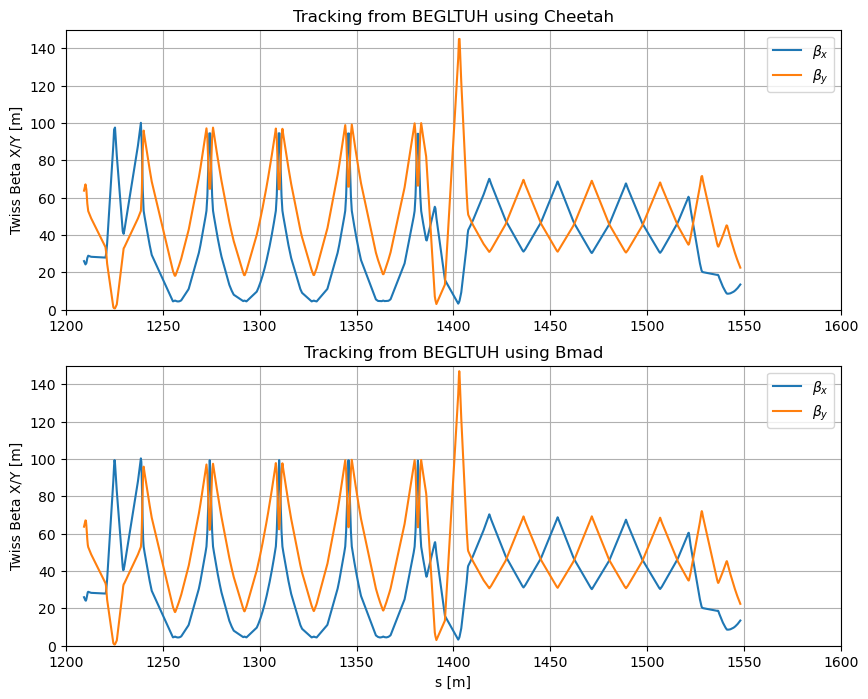

In [19]:
xlims = [1200, 1600]
ylims = [0,150]

track_start_element_name = track_start_element_name.strip().upper()

# Find Bmad start index
name_array = np.array([name.strip().upper() for name in bmad_output['ele.name']])
bmad_start_index = np.where(name_array == track_start_element_name)[0]

if len(bmad_start_index) == 0:
    raise ValueError(f"Element name '{track_start_element_name}' not found in Bmad output.")

bmad_start_s = bmad_output['ele.s'][bmad_start_index[0]]

s = cheetah_output['s']
cheetah_beta_x = cheetah_output['beta_x']
cheetah_beta_y = cheetah_output['beta_y']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  

# Plot Cheetah output
ax1.set_title(f'Tracking from {track_start_element_name} using Cheetah')
ax1.plot(s + bmad_start_s, cheetah_beta_x, label=r'$\beta_x$')
ax1.plot(s + bmad_start_s, cheetah_beta_y, label=r'$\beta_y$')
ax1.set_ylabel('Twiss Beta X/Y [m]')

if xlims:
    ax1.set_xlim(xlims)
if ylims:
    ax1.set_ylim(ylims)

ax1.grid()
ax1.legend()

# Plot Bmad output
ax2.set_title(f'Tracking from {track_start_element_name} using Bmad')
ax2.set_xlabel('s [m]')
ax2.set_ylabel('Twiss Beta X/Y [m]')
ax2.plot(bmad_output['ele.s'], bmad_output['ele.a.beta'], label=r'$\beta_x$')
ax2.plot(bmad_output['ele.s'], bmad_output['ele.b.beta'], label=r'$\beta_y$')

if xlims:
    ax2.set_xlim(xlims)
if ylims:
    ax2.set_ylim(ylims)

ax2.grid()
ax2.legend()

plt.show()

In [23]:
cheetah_alpha_x = cheetah_output['alpha_x']
cheetah_alpha_y = cheetah_output['alpha_y']

alpha_x=cheetah_alpha_x[-1]
alpha_y=cheetah_alpha_y[-1]
beta_x=cheetah_beta_x[-1]
beta_y=cheetah_beta_y[-1]




In [24]:
# define transformed model class
class TransformedModel(torch.nn.Module):
    def __init__(self, model, input_transformer, output_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer
    
    def forward(self, x):
        x = self.input_transformer(x)
        x = self.model(x)
        x = self.output_transformer.untransform(x)
        return x



In [26]:
import torch
import joblib
import numpy as np

# Load the full model

# load base model and transformers
model = torch.load("./model/FELmodel_model.pt")
inputs_to_nn = torch.load("./model/input_transform.pt")
outputs_to_nn = torch.load("./model/output_transform.pt")



# create transformed model
transformed_model = TransformedModel(
    model=model, 
    input_transformer=inputs_to_nn,
    output_transformer=outputs_to_nn,
).to(torch.double)
transformed_model

# Define your new inputs
alpha_x = cheetah_alpha_x[-1]
alpha_y = cheetah_alpha_y[-1]
beta_x = cheetah_beta_x[-1]
beta_y = cheetah_beta_y[-1]
taper = torch.tensor([0.03])  # Replace `your_taper_value` with the appropriate taper value
emit_x=torch.tensor([emittance_x]) 
emit_y=torch.tensor([emittance_y]) 
#taper = [0.0]  # Replace `your_taper_value` with the appropriate taper value
#emit_x=emittance_x
#emit_y=emittance_y  


print(emit_y)
# Correct the shape by removing the extra dimension
# Correct the shape by creating input_features as a 1D array (1, 7)
input_features = np.array([alpha_x, alpha_y, beta_x, beta_y, emit_x, emit_y, taper])#.reshape(1, 7)

# Convert to a 2D PyTorch tensor with the correct shape (1, 7)
input_tensor = torch.tensor([alpha_x, alpha_y, beta_x, beta_y, emit_x, emit_y, taper], dtype=torch.double)




# Make predictions using the model
with torch.no_grad():
    predicted_energy = transformed_model(input_tensor)


predicted_energy = predicted_energy.numpy()


# Print or return the predicted energy value
print(f'Predicted Energy: {predicted_energy[0]:.4f} μJ')


tensor([1.0000e-06])
Predicted Energy: 28.0978 μJ


/lscratch/jmorgan/tmp/ipykernel_1081243/92294261.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./model/FELmodel_model.pt")
/lscratch/jmorgan/tmp/ip